In [3]:
import numpy as np
import sys
import gym
from gym import error, spaces
from gym import utils
from gym.utils import seeding
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from simulator.utils import Cube2D, Transform2D

In [34]:
class Gaussian(gym.Space):
    """
    A Gaussian space randomizes an action as a datapoint
    using a location and a covariance.
    
    This is actually a multivariate normal distribution (MVN),
    but with non-correlated variables 
    (the covariance matrix is diagonal and positive)
    
    A sample usage:
    self.action_space = Gaussian(location = [-1,2], diagonal_cov = [1,1])
    """
    def __init__(self, location, diagonal_cov, n_objects = 2, shape=None):
        """
        Two kinds of valid inputs
        
        - location and diagonal_cov are scalar -> Gaussian distribution
        - location and diagonal_cov are np array of same size
        """
        self.n_objects = n_objects
        
        if np.isscalar(location) and np.isscalar(diagonal_cov):
            """Gaussian distribution"""
            self.location = np.array([location])
            self.diagonal_cov = np.array([diagonal_cov])
            self.shape = (1,)
        elif isinstance(location, list) and isinstance(diagonal_cov, list):
            assert len(location) == len(diagonal_cov)
            
            self.location = np.array(location)
            self.diagonal_cov = np.diag(diagonal_cov)
            
            self.shape = self.location.shape
        else:
            assert isinstance(location, np.ndarray)
            assert isinstance(diagonal_cov, np.ndarray)
            assert location.shape == diagonal_cov.shape
        
            self.shape = location.shape
            
            self.location = np.flatten(location)
            self.diagonal_cov = np.diag(np.flatten(diagonal_cov))
            
    def sample(self, object_index = None):
        """
        sample an action to take:
        
        if object_index == None:
            sample both object_index and location of final point
        else:
            sample jus the location of final point
        """
        s = np.random.multivariate_normal(self.location, self.diagonal_cov)
        
        # Reshape to original 
        s.shape = self.shape
        
        if object_index:
            return (object_index, s)
        else:
            object_index = np.random.choice(self.n_objects)
            return (object_index, s)
            
    def __repr__(self):
        return "MVN (location= " + str(self.location) + "; variances = " + str(self.diagonal_cov) +")"
    
    def __eq__(self, other):
        return np.allclose(self.location, other.location) and \
                np.allclose(self.diagonal_cov, other.diagonal_cov)

In [55]:
class Uniform(gym.Space):
    """
    A uniform distributioin in a bounded 
    N-dimensional cube
    
    A sample usage:
    Create a square (-1,-1), (-1,1), (1,1), (1,-1)
    self.state_space = Uniform(p = [-1,-1], dimension = [2,2])
    """
    def __init__(self, p, dimension, randomizer = np.random):
        self.p = np.array(p)
        self.dimension = np.array(dimension)
        self.p_opposite = self.p + self.dimension
        self.randomizer = randomizer
        
    def sample(self):
        return self.randomizer.uniform(self.p, self.p_opposite)
    
    def __repr__(self):
        return "Uniform (p= " + str(self.p) + "; dimension = " + str(self.dimension) +")"
    
    def __eq__(self, other):
        return np.allclose(self.p, other.p) and \
                np.allclose(self.dimension, other.dimension)

In [46]:
def make_lines(shape):
    lines = []
    for i in range(len(shape)):
        j = (i + 1) % len(shape)
        lines.append( [ shape[i], shape[j] ] )
    
    return lines

In [69]:
from matplotlib import pyplot as plt
import pylab as pl
from matplotlib import collections as mc

In [71]:
colors = [ (1, 0, 0, 1), (0,1,0,1), (0,0,1,1) ]

In [107]:
from simulator.simulator2d import Environment

In [101]:
class BlockMovementEnv(gym.Env):
    reward_range = (0, 1)
    metadata = {'render.modes': ['human']}
    """
    """
    def __init__(self, target, playground_x = [-1,-1, 0],
                 playground_dim = [2, 2, np.pi/2], name=None, n_objects = 2,
                block_size = 0.15, 
                 progress_threshold = 0.9):
        """
        Parameters:
        - name: the name of the event action to be learned
        - target: is a function that produces
        a value between 0 and 1 (event progress function)
        - playground: a rectangle (x, y, rot, width, height, rot_range)
        where (x,y) is a corner of the rectangle
        - block_size: the default size for a block
        - n_objects: number of objects to be randomized
        - progress_threshold: condition for an episode to end
        
        **Note**
        target_function:
        event progress function will be defined based on the event type 
        currently learned
        
        target_function would be an LSTM
        
        
        """
        # This env is just a wrapper around an environment that 
        # I have created before
        self.e = Environment()
        self.target = target
        self.n_objects = n_objects
        self.playground_x = playground_x
        self.playground_dim = playground_dim
        self.name = name
        self.block_size = block_size
        
        # Action space is dynamically created
        # The action space would be a combination of a 
        self.action_space = None
        # observation space is a subset of multiple object spaces
        self.observation_space = None 
        
        self._seed()
        
        self.object_space = Uniform(p = playground_x, 
                                         dimension = playground_dim, 
                                         randomizer = self.np_random)
        
        
        self._reset()
        
    def _step(self, action):
        # action is generated from the action_policy (external to the environment)
        object_index, position = action
        
        self.s[object_index] = self.s[object_index] + position
        self.lastaction = action
        
        
        current_progress = self.target.predict()
        
        return (self.s)
    
    def _reset(self):
        self.s = []
        # states would be a list of location/orientation for block
        # sampled from the observation space
        for i in range(self.n_objects):
            state = self.object_space.sample()
            self.s.append(state)
        
        self.lastaction=None
        return self.s

    def _render(self, mode='human', close=False):
        if close:
            return
        
        fig, ax = plt.subplots()
        ax.set_xticks(np.arange(self.playground_x[0], 
                                self.playground_x[0] + self.playground_dim[0], 0.1))
        ax.set_yticks(np.arange(self.playground_x[1], 
                                self.playground_x[1] + self.playground_dim[1], 0.1))
        ax.set_xlim([self.playground_x[0], 
                     self.playground_x[0] + self.playground_dim[0]])
        ax.set_ylim([self.playground_x[1], 
                     self.playground_x[1] + self.playground_dim[1]])
        fig.set_size_inches(20, 12)
        
        for i in range(self.n_objects):
            # Obj is action position and rotation of object
            obj = self.s[i]
            position = obj[:2]
            rotation = obj[2]
            scale = self.block_size / 2
            
            c = Cube2D(transform = Transform2D(position, rotation, scale))
            
            shape = c.get_markers()
            
            lines = make_lines(shape)
            lc = mc.LineCollection(lines, colors=colors[i], linewidths=2)
            ax.add_collection(lc)
        
        ax.autoscale()
        ax.margins(0.1)

        plt.show()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [110]:
env = BlockMovementEnv(None)

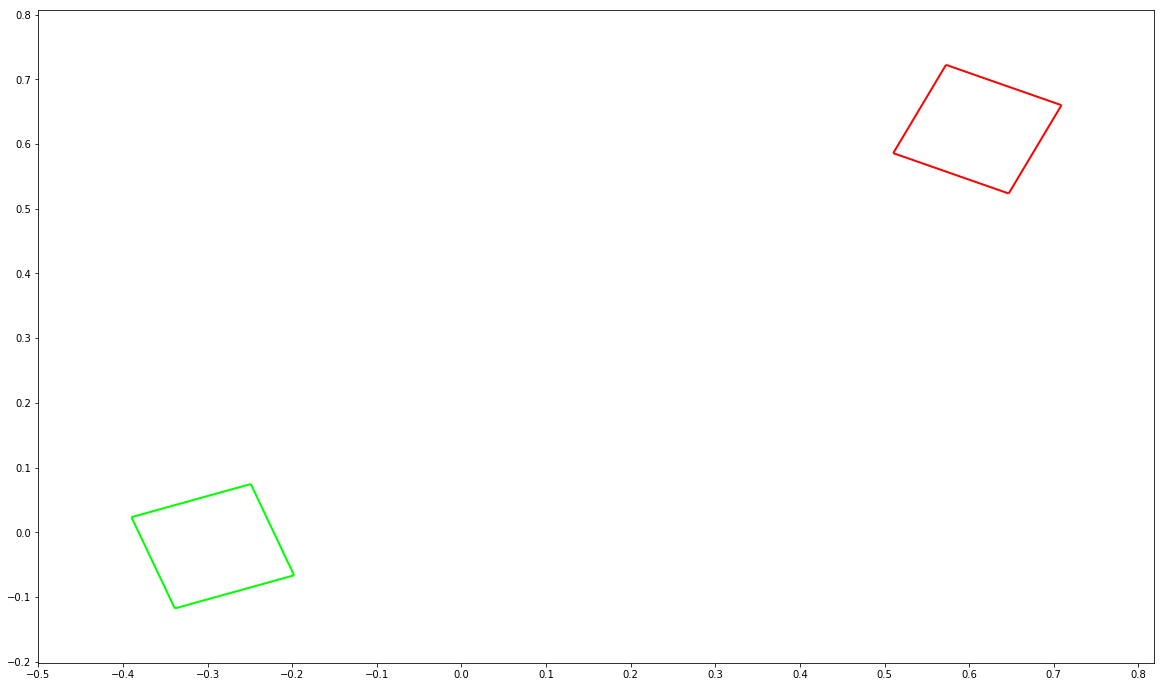

In [119]:
env.reset()
env.render()

In [120]:
class ProgressConfig(object):
    s2s = False

class EventProgressEstimator(object):
    """
    Estimate the progress of event using LSTM
    """
    def __init__(self, is_training, name=None, config = ProgressConfig()):
        self.num_steps = num_steps = config.num_steps
        self.n_input = n_input = config.n_input
        self.size = size = config.hidden_size
        # This is an option, if self.s2s = True -> Use all progress values
        # otherwise just use the last progress value
        self.s2s = config.s2s 
        
        with tf.variable_scope(name):
            "Declare all placeholders"
            "Placeholder for input"
            
            """
            batch_size
            num_steps: length of sequence
            n_input: size of feature vectors
            """
            self._input_data = tf.placeholder(tf.float32, [None, num_steps, n_input])
            
            """
            (batch_size x num_steps) for sequence to sequence
            batch_size for 
            """
            if self.s2s:
                self._targets = tf.placeholder(tf.float32, [None, num_steps])
            else:
                self._targets = tf.placeholder(tf.float32, [None])
            
            lstm_cell = BasicLSTMCell(size, forget_bias = 1.0, state_is_tuple=True)
            
            if is_training and config.keep_prob < 1:
                lstm_cell = DropoutWrapper(lstm_cell, output_keep_prob=config.keep_prob)
                
            multi_lstm_cell = MultiRNNCell([lstm_cell] * config.num_layers, state_is_tuple=True)
            
            # Initial states of the cells
            # cell.state_size = config.num_layers * 2 * size
            # Size = ( batch_size x cell.state_size )
            
            # We don't know the batch_size here, so don't need
            # to specify initial_state
            # self._initial_state = multi_lstm_cell.zero_state(batch_size, tf.float32)
            
            inputs = tf.reshape(self._input_data, [-1, n_input]) # (batch_size * num_steps, n_input)
            
            with tf.variable_scope("linear"):
                weight = tf.get_variable("weight", [n_input, size])
                bias = tf.get_variable("bias", [size])

                # (batch_size * num_steps, size)
                inputs = tf.matmul(inputs, weight) + bias
                
            inputs = tf.reshape(inputs, (-1, num_steps, size)) # (batch_size, num_steps, size)
            
            # (output, state)
            # output is of size:  ( batch_size, num_steps, size ) or (( batch_size, size ))
            # state is of size:   ( batch_size, cell.state_size ) (last state only)
            with tf.variable_scope("lstm"):
                output_and_state = tf.nn.dynamic_rnn(multi_lstm_cell, inputs, dtype=tf.float32)
            
            output = output_and_state[0]
            # we will pass the hidden state to next run of lstm
            self._final_state = output_and_state[1]
            
            with tf.variable_scope("output_linear"):
                weight = tf.get_variable("weight", [size, 1])
                bias = tf.get_variable("bias", [1])

                
                if self.s2s:
                    # Need to reshape to 2 dimensions
                    output = tf.reshape(output, [-1, size])
                    output = output @ weight + bias
                    # ( batch_size, num_steps )  
                    output = tf.reshape(output, [-1, num_steps])
                else:
                    #( batch_size, 1)
                    # @ is the same as matmul
                    output = output @ weight + bias
                    
            # Remove all 1 dimension
            # ( batch_size, num_steps ) or (batch_size)
            self.output = tf.squeeze(output)
            
            # Loss = mean squared error of target and predictions
            self.loss = tf.losses.mean_squared_error(self._targets, output)
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def checkInputs(self, inputs):
        assert isinstance(inputs, np.ndarray)
        
        assert len(inputs.shape) == 3
        assert inputs.shape[1] == self.num_steps
        assert inputs.shape[2] == self.n_input
    
    def checkOutputs(self, outputs, batch_size):
        assert isinstance(outputs, np.ndarray)
        if self.s2s:
            assert len(outputs.shape) == 2
            assert outputs[0] == batch_size
            assert outputs[1] == self.num_steps
        else:
            assert len(outputs.shape) == 1
            assert outputs[0] == batch_size
            
        
    def update(self, inputs, outputs, sess=None):
        """
        inputs: np.array (batch_size, num_steps, n_input)
        outputs: np.array (batch_size, num_steps) or (batch_size)
        
        We need to run train_op to update the parameters
        We also need to return its loss
        """
        self.checkInputs(inputs)
        
        batch_size = inputs.shape[0]
        
        self.checkOutputs(outputs, batch_size)
        
        sess = sess or tf.get_default_session()
        _, loss = sess.run([self.train_op, self.loss], 
                           {self._input_data: inputs, self._targets: outputs})
        
        return loss
    
    def predict(self, inputs, outputs = None, sess=None):
        """
        inputs: np.array (batch_size, num_steps, n_input)
        outputs: np.array (batch_size, num_steps) or (batch_size)
        
        This function would not run train_op
        outputs is only optional if we want to get the loss
        """
        self.checkInputs(inputs)
        
        if outputs != None:
            batch_size = inputs.shape[0]
            self.checkOutputs(outputs, batch_size)
        
        sess = sess or tf.get_default_session()
        
        if outputs != None:
            predicted, loss = sess.run([self.output, self.loss],
                    {self._input_data: inputs, self._targets: outputs})
            return (predicted, loss)
        else:
            predicted = sess.run(self.output,
                    {self._input_data: inputs})
            return predicted

In [123]:
from utils import DATA_DIR, FIRST_EXPERIMENT_CLASSES,\
    SESSION_NAME, SESSION_OBJECTS, SESSION_EVENTS, GLYPH_BOX, NORMAL, \
    START, END, LABEL
from read_utils import load_one_param_file

In [124]:
session_1 = load_one_param_file(os.path.join( DATA_DIR, 'SlideAround', 'Session1', 'files.param'))
session_2 = load_one_param_file(os.path.join( DATA_DIR, 'SlideAround', 'Session2', 'files.param'))

'NoneType' object has no attribute 'findall'
'NoneType' object has no attribute 'findall'


In [133]:
qsr_lib_src = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(qsr_lib_src)

from qsrlib.qsrlib import QSRlib

In [132]:
sys.path = ['', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\python35.zip', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\DLLs', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib', 'C:\\Anaconda3\\envs\\tensorflow-cpu', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Tuan Do\\.ipython', 'D:\\git\\learn-to-perform']

In [134]:
from qsrlib.qsrlib import QSRlib, QSRlib_Request_Message
from qsrlib_io.world_trace import Object_State, World_Trace

from feature.project_table import project_markers, estimate_cube_2d
from utils import SESSION_OBJECTS, SESSION_LEN, BLOCK_SIZE, ROTATION_QUANTIZATION

In [135]:
def qsr_feature_extractor ( qsrlib, object_data, object_1_name, object_2_name, session_len ):
    '''
    feature_selection between two objects
    # of features = 13
    
    8 features here
    (o1.position, o2.position) - cardir, cardir_diff, argd, argd_diff, qtccs 4 features

    -- other features
    
    2 features
    quantized rotation of two objects
    1 feature
    quantized rotation difference between two objects
    2 features
    quantized difference of rotations btw two frames of two objects
    '''
    object_1 = object_data[object_1_name]
    object_2 = object_data[object_2_name]

    o1 = [Object_State(name="o1", timestamp=i, x=object_1[i].transform.position[0][0], y=object_1[i].transform.position[0][1]) 
            for i in range(session_len)]
    o2 = [Object_State(name="o2", timestamp=i, x=object_2[i].transform.position[0][0], y=object_2[i].transform.position[0][1]) 
            for i in range(session_len)]

    world = World_Trace()
    world.add_object_state_series(o1)
    world.add_object_state_series(o2)

    qsrlib_request_message = QSRlib_Request_Message(which_qsr=['cardir', 'argd', 'qtccs'], input_data=world, 
                    dynamic_args = {'cardir': {'qsrs_for': [('o1', 'o2')]},
                                    'argd': {'qsrs_for': [('o1', 'o2')], 
                                            'qsr_relations_and_values' : dict(("" + str(i), i * BLOCK_SIZE / 2) for i in range(20)) },
                                    'qtccs': {'qsrs_for': [('o1', 'o2')], 
                                              'quantisation_factor': 0.001, 'angle_quantisation_factor' : np.pi / 5,
                                              'validate': False, 'no_collapse': True
                                   }})

    # Number of features that you calculate the difference between two consecutive frames
    diff_feature = 2
    try:
        # pretty_print_world_qsr_trace(['cardir', 'mos', 'argd', 'qtccs'], qsrlib_response_message)
        qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

        # (#frame, 8)
        qsr_feature = turn_response_to_features([('o1,o2')], qsrlib_response_message, diff_feature)

        # rotation features
        quantized_r_1 = np.array([object_1[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
        quantized_r_2 = np.array([object_2[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
        quantized_diff = quantized_r_1 - quantized_r_2
        diff_quantized_r_1 = np.pad(np.ediff1d(quantized_r_1), (1,0), 'constant', constant_values = (0,))
        diff_quantized_r_2 = np.pad(np.ediff1d(quantized_r_2), (1,0), 'constant', constant_values = (0,))

        # column forms
        quantized_r_1.shape = (session_len, 1)
        quantized_r_2.shape = (session_len, 1)
        quantized_diff.shape = (session_len, 1)
        diff_quantized_r_1.shape = (session_len, 1)
        diff_quantized_r_2.shape = (session_len, 1)

        return np.concatenate([qsr_feature, quantized_r_1, quantized_r_2, quantized_diff, diff_quantized_r_1, diff_quantized_r_2], axis = 1)

    except ValueError as e:
        print (e)
        print ('Problem in data of length ' + str(len_data))
        return []

cdid = dict( (u, i) for (i, u) in enumerate( ['n', 'nw', 'w', 'sw', 's', 'se', 'e', 'ne', 'eq'] ))
mosd = dict( (u, i) for (i, u) in enumerate( ['s', 'm'] ))
qtcc_relations = dict( (u, i) for (i, u) in enumerate( ['-', '0', '+'] ))

def cardir_index ( cardir ):
    return cdid [cardir]

def mos_index ( mos ):
    return mosd [mos]

def qtcc_index ( qtcc_relation ):
    return qtcc_relations [qtcc_relation] - 1

'''
diff_feature: number of features at the beginning that need to create difference between two frames
all_feature: total number of features
'''
def turn_response_to_features(keys, qsrlib_response_message, diff_feature):
    feature_chain = []
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        features = []
        # print (qsrlib_response_message.qsrs.trace[t].qsrs.keys())
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]
                
                if 'cardir' in v.qsr:
                    f = v.qsr['cardir']
                    features.append(cardir_index(f))
                if 'argd' in v.qsr:
                    f = int( v.qsr['argd'] )
                    features.append(f)
        # Just to separate qtccs at the end of feature vectors
        
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]
                if 'qtccs' in v.qsr:
                    fs = v.qsr['qtccs']
                    features += [qtcc_index(f) for f  in fs.split(',')]
        
        # print features
        feature_chain.append(features)
    
    if len(feature_chain) == 0:
        return feature_chain

    # The first frame doesn't has qtcc relations
    feature_chain[0] += [0 for i in range(4)]

    feature_chain = np.array(feature_chain)
    
    print (feature_chain.shape)
    # number of features
    f_number = feature_chain.shape[1]

    # Feature that need to calculate diff
    # (#frame, diff_feature)
    need_diff_chain = feature_chain[:, :diff_feature]

    # Get the diff
    # (#frame - 1, diff_feature)
    diff_chain = np.diff(need_diff_chain, n=1, axis = 0)

    # (#frame, diff_feature)
    padded_diff_chain = np.pad(diff_chain, [(1,0), (0,0)], 'constant', constant_values = (0,))

    
    
    # Add for the first frame
    # (#frame, 2 * diff_feature + other_feature)
    diff_feature_chain = np.concatenate ( [need_diff_chain, padded_diff_chain, feature_chain[:, diff_feature:]], axis = 1 )
    
    print ('shape of diff_feature_chain %s' % str(diff_feature_chain.shape))
    return diff_feature_chain

In [139]:
%matplotlib inline

from feature.project_table import project_markers, estimate_cube_2d
from simulator.utils import Cube2D, Transform2D
from matplotlib import pyplot as plt
import bisect

def count_finite( numpy_array ):
    return np.sum( np.isfinite( numpy_array )) 

'''
Area of polygons
===========
Params: numpy_array of size ( 3 x n )

Return: object_data: Dictionary
'''
def area_dimension( numpy_array ):
    s = np.reshape(numpy_array, (len(numpy_array)//3,3))
    x = s[:,0]
    y = s[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def project_to2d_ ( session_data ):
    object_data = {}

    for object_name in session_data[SESSION_OBJECTS]:
        if object_name == 'table':
            polygon = []
            for frameNo in session_data[SESSION_OBJECTS][object_name]:
                frame_polygon = session_data[SESSION_OBJECTS][object_name][frameNo]

            polygon.append(frame_polygon)

            polygon = np.concatenate(polygon)
            polygon = np.reshape(polygon, (len(polygon)//3, 3) )
            
            table_markers = polygon

            # Just pick the first two points for coordination
            first_point = table_markers[0]
            second_point = table_markers[1]
    
    for object_name in session_data[SESSION_OBJECTS]:
        if object_name != 'table':
            object_data[object_name] = {}
            for frameNo in session_data[SESSION_OBJECTS][object_name]:
                frame_data = session_data[SESSION_OBJECTS][object_name][frameNo]

                # Sort firstly by number of non-finite corners
                # Sort secondly by size of marker (larger marker means better resolution)
                # Size of marker should be only based on first two dimensions
                # The third dimension might be very noisy
                q = [((count_finite(frame_data[face_index]), area_dimension(frame_data[face_index]) ), face_index) 
                    for face_index in frame_data]
                q = sorted(q, key = lambda t: t[0], reverse = True)

                # Pick out the face_index with the most number of non-infinite values
                best_face_index = q[0][1]
                #print ('-----------')
                #print (frame_data[best_face_index])
                rectangle_projected = project_markers ( frame_data[best_face_index], table_markers )
                #print (rectangle_projected)
                object_data[object_name][int(frameNo)] = estimate_cube_2d ( rectangle_projected, first_point, second_point )

    return object_data



def interpolate_object_data( session_len, one_object_data ):
    sorted_keys = sorted(one_object_data.keys())
    for frame in range(session_len):
        if frame not in one_object_data:
            # missing frame
            frame_position = bisect.bisect_left(sorted_keys, frame)

            if frame_position == 0:
                # missing at the beginning
                one_object_data[frame] = one_object_data[sorted_keys[0]]
            elif frame_position == len(sorted_keys):
                # missing at the end
                one_object_data[frame] = one_object_data[sorted_keys[-1]]
            else:
                pre_key = sorted_keys[frame_position - 1]
                nex_key = sorted_keys[frame_position]
                pre = one_object_data[pre_key].transform
                nex = one_object_data[nex_key].transform
                
                p = (frame - pre_key)/(nex_key - pre_key)
                q = (nex_key - frame)/(nex_key - pre_key)
                transfrom = Transform2D ( nex.position * q + pre.position * p , 
                                         nex.rotation * q + pre.rotation * p, 
                                         nex.scale * q + pre.scale * p)
                one_object_data[frame] = Cube2D( transfrom )

In [140]:
qsrlib = QSRlib()

object_data_1 = project_to2d_(session_1)
object_data_2 = project_to2d_(session_2)

C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in float_scalars
D:\git\learn-to-perform\feature\project_table.py:112: RuntimeWarning: invalid value encountered in true_divide
  
C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\numpy\linalg\linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Exception: You need at least 3 non-finite points to find a plane

In [ ]:
len(object_data_1['Stella Artois'])

In [ ]:
features_1 = qsr_feature_extractor(qsrlib, project_to2d_(session_1), 'Stella Artois', 'Shell', 2881)
features_2 = qsr_feature_extractor(qsrlib, project_to2d_(session_2), 'Stella Artois', 'Shell', 2881)